In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm

from dpp.data.network import PPINetwork
from dpp.util import Params, prepare_sns
from dpp.data.associations import load_diseases
from dpp.experiments.protein_significance import ProteinSignificance

os.chdir("../")

## Protein Significance

In [2]:
protein_sig_df = pd.read_csv("experiments/protein_significance/samples_1000/results.csv")

In [3]:
protein_sig_df.keys()

Index(['disease', 'protein', 'common_interactor_score',
       'common_interactor_score_pvalue', 'degree', 'frac_direct_interactions',
       'frac_direct_interactions_pvalue'],
      dtype='object')

In [28]:
ci_sig = protein_sig_df["common_interactor_score_pvalue"] < 0.05
di_sig = protein_sig_df["frac_direct_interactions_pvalue"] < 0.05 

In [34]:
ci_sig_di_nsig = np.logical_and(ci_sig, np.logical_not(di_sig))
ci_nsig_di_sig =  np.logical_and(di_sig, np.logical_not(ci_sig))

In [32]:
np.mean(ci_sig_di_nsig)

0.15384716941275878

In [35]:
np.mean(ci_nsig_di_sig)

0.021216201943388257

In [17]:
np.mean(di_sig)

0.17782266582171524

In [18]:
np.mean(ci_sig)

0.3104536332910858

In [36]:
np.mean(ci_sig) - np.mean(ci_sig_di_nsig)

0.156606463878327

In [37]:
np.mean(di_sig) - np.mean(ci_nsig_di_sig)

0.156606463878327

In [41]:
np.mean(protein_sig_df["frac_direct_interactions"] == 0)

0.46511934938741023

## DPP Performance

In [20]:
dpp_df = pd.read_csv("experiments/aggregation/results.csv", header=[0, 1], index_col=0)
dpp_df

data  \
                                                     name   
C4020858                                Choreatic disease   
C4020859                          Pyramidal tract disease   
C2675111                               Abnormal eyelashes   
C0003803                       Arnold Chiari Malformation   
C1837082                              Metaphyseal cupping   
C4020851  Cortical white matter abnormalities seen on MRI   
C0033941                     Psychoses, Substance-Induced   
C4020854                       Neuro-degenerative disease   
C1837087                       Macular pigmentary changes   
C1837084                                 Short metacarpal   
C0079924                                  Oligohydramnios   
C0003578                                            Apnea   
C0332606                                     Elfin facies   
C1866730                                       Rhizomelia   
C0240310                        Hypoplasia of the maxilla   
C0241210                                     Speech Delay   
C0027720                                        Nephrosis   
C0026636                                   Mouth Diseases   
C4021107                      Non-obstructive azoospermia   
C0026633                              Mouth Abnormalities   
C2219717      menstrual periods stopped for over 6 months   
C1837404                              High, narrow palate   
C1837402                                     Flat occiput   
C0746940                                        nonverbal   
C0043352                                       Xerostomia   
C0206698                               Cholangiocarcinoma   
C0231835                                        Tachypnea   
C1389016                    ATRIOVENTRICULAR CANAL DEFECT   
C1864897                                  Cognitive delay   
C0221210              Congenital malrotation of intestine   
...                                                   ...   
C1842774                           Hyperpigmented macules   
C1837081                                    Tibial bowing   
C0004364                              Autoimmune Diseases   
C0021390                      Inflammatory Bowel Diseases   
C0037268                               Skin Abnormalities   
C0575158                Kyphoscoliosis deformity of spine   
C0015644                           Muscular fasciculation   
C0152021                         Congenital heart disease   
C0152025                                   Polyneuropathy   
C0333641                                         Atrophic   
C4280269                                Noncancerous mole   
C0002994                                       Angioedema   
C0042487                                Venous Thrombosis   
C0002622                                          Amnesia   
C4277682           Chemical and Drug Induced Liver Injury   
C0005695                                 Bladder Neoplasm   
C0010200                                         Coughing   
C1849311                          Short first metacarpals   
C0037317                               Sleep disturbances   
C0037315                            Sleep Apnea Syndromes   
C1866241                                       Broad feet   
C1842170       Centrally nucleated skeletal muscle fibers   
C0014170                            Endometrial Neoplasms   
C0521573                               Coloboma of eyelid   
C0014175                                    Endometriosis   
C0028949                                   Oligomenorrhea   
C0027430                                     Nasal Polyps   
C0086437                                     Joint laxity   
C0086439                                      Hypokinesia   
C0311277                               Obesity, Abdominal   

                                   loo_ptest[DP]                         \
                             class  disease_size pvalue_COMP pvalue_DNS   
C4020858                       NaN            28        0.0

In [7]:
# difference in recall-at-25
comparison = "rw"
diff = (dpp_df["lci_dpp[DP]", "Recall-at-100"] - dpp_df[f"{comparison}_dpp[DP]", "Recall-at-100"] >= 0).mean()
diff_df = pd.DataFrame(dpp_df["lci_dpp[DP]", "Recall-at-100"] - dpp_df[f"{comparison}_dpp[DP]", "Recall-at-25"],
                 columns=["diff"])
diff_df.index.name = "id"
print(diff)

0.7603533959138598


In [22]:
lci_recall_100 = dpp_df["lci_dpp[DP]", "Recall-at-100"]
lci_name = dpp_df["data", "name"]
gcn_recall_100 = pd.read_csv("experiments/dpp_evaluate/gcn/metrics.csv", index_col=0)["Recall-at-100"].loc[lci_recall_100.index]
df = pd.DataFrame({"gcn_recall_100": gcn_recall_100, "lci_recall_100": lci_recall_100, 'name':lci_name})
df.to_csv("experiments/dpp_evaluate/gcn/lcivgcn.csv")

In [9]:
dpp_recall_100 = dpp_df["lci_dpp[DP]", "Recall-at-100"]

In [69]:
# difference in recall-at-25
comparison = "diamond"
(dpp_df["lci_dpp[DP]", "Recall-at-25"] - dpp_df[f"{comparison}_dpp[DP]", "Recall-at-25"] >= 0).mean()

0.8415240198785201

In [70]:
# difference in recall-at-25
comparison = "node2vec"
(dpp_df["lci_dpp[DP]", "Recall-at-25"] - dpp_df[f"{comparison}_dpp[DP]", "Recall-at-25"] >= 0).mean()

0.9099944781888459

### Disease Classes

In [72]:
classes_df = pd.read_csv("data/disease_classes/disgenet-classes.csv", index_col=0)

In [73]:
classes_df

,name,class,size
id,,,
C4020858,Choreatic disease,NaN,28
C4020859,Pyramidal tract disease,NaN,12
C2675111,Abnormal eyelashes,NaN,13
C0003803,Arnold Chiari Malformation,NaN,11
C1837082,Metaphyseal cupping,NaN,11
C4020851,Cortical white matter abnormalities seen on MRI,NaN,18
C1837081,Tibial bowing,NaN,20
C4020854,Neuro-degenerative disease,NaN,43
C4020855,Respiratory function loss,NaN,129


In [134]:
joined_df = diff_df.join(classes_df)


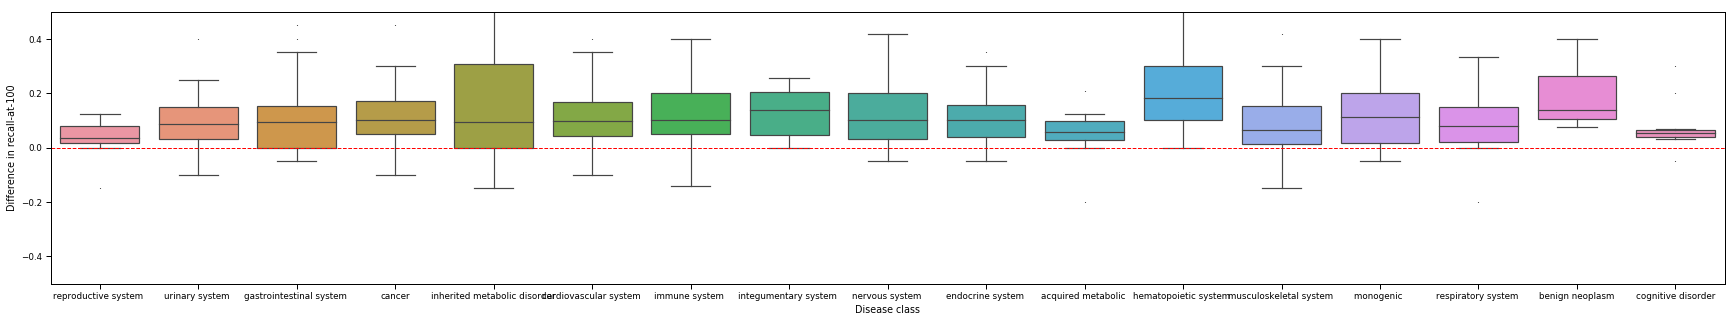

In [141]:
plt.figure(figsize=(30,5))
sns.boxplot(data=joined_df, y="diff", x="class", fliersize=0.3)
plt.axhline(linewidth=1, color='r', linestyle="--")
plt.ylim((-0.5, 0.5))
plt.xlabel("Disease class")
plt.ylabel("Difference in recall-at-100")
plt.savefig("experiments/dpp_evaluate/_figures/disease_classes/disease_class_box.pdf")

In [144]:
joined_df.groupby(by="class").mean()

,diff,size
class,,
acquired metabolic,0.052425,68.285714
benign neoplasm,0.185952,26.800000
cancer,0.119757,56.133333
cardiovascular system,0.111956,49.173913
cognitive disorder,0.079708,212.900000
endocrine system,0.108322,28.833333
gastrointestinal system,0.112501,37.514286
hematopoietic system,0.208810,33.619048
immune system,0.113197,27.588235


## Gene Ontology Enrichment

In [25]:
lci_go_results = pd.read_csv("experiments/go_enrichment/lci/results.csv", index_col=0)
rw_go_results = pd.read_csv("experiments/go_enrichment/random_walk/results.csv", index_col=0)
lci_go_results

,disease_name,disease_num_significant,disease_top_10,lci_jaccard_sim,lci_num_significant,lci_top_10
C0240063,Coloboma of iris,220,{'regulation of multicellular organismal devel...,0.241135,305,{'negative regulation of biosynthetic process'...
C0029456,Osteoporosis,1241,"{'response to chemical', 'response to stimulus...",0.307042,2007,"{'response to chemical', 'response to oxygen-c..."
C0220994,Hyperammonemia,249,"{'urea cycle', 'carboxylic acid metabolic proc...",0.210526,119,"{'carboxylic acid metabolic process', 'small m..."
C0271388,Pendular Nystagmus,37,"{'sensory perception', 'detection of abiotic s...",0.035294,51,"{'cAMP metabolic process', ""3',5'-cyclic-AMP p..."
C0019196,Hepatitis C,163,"{'response to stress', 'response to stimulus',...",0.000000,1,"{'lipase activity', 'high-density lipoprotein ..."
C1865992,Short hallux,291,{'positive regulation of animal organ morphoge...,0.311321,265,{'enzyme linked receptor protein signaling pat...
C0013604,Edema,751,"{'response to stimulus', 'extracellular region...",0.251466,956,"{'signal transduction', 'cell surface receptor..."
C0018916,Hemangioma,97,{'regulation of cell population proliferation'...,0.007519,37,"{'intracellular organelle lumen', 'vitamin bin..."
C0017574,Gingivitis,0,{'positive regulation of NF-kappaB transcripti...,0.000000,15,"{'supramolecular polymer', 'intermediate filam..."
C0004245,Atrioventricular Block,7,"{'voltage-gated sodium channel complex', 'volt...",0.000000,107,{'inward rectifier potassium channel activity'...


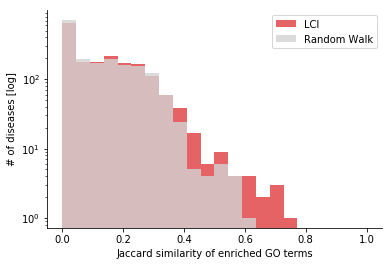

In [12]:
sns.distplot(lci_go_results["lci_jaccard_sim"], bins=22, kde=False, label="LCI", hist_kws={"range": (0, 1),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(rw_go_results["lci_jaccard_sim"], bins=22, kde=False, label="Random Walk", hist_kws={"range": (0, 1),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('log')
plt.xlabel("Jaccard similarity of enriched GO terms")
plt.ylabel("# of diseases [log]")
plt.legend()

In [24]:
lci_median = np.median(lci_go_results['lci_jaccard_sim'])
print(f"LCI Median: {lci_median}")
rw_median = np.median(rw_go_results['lci_jaccard_sim'])
print(f"RW Median: {rw_median}")
percent_increase = (lci_median - rw_median)/rw_median
print(f"Percent Increase: {percent_increase}")

LCI Median: 0.11055276381909547
RW Median: 0.09216589861751152
Percent Increase: 0.19949748743718582
